Data description at the [codalab 26655 competition](https://competitions.codalab.org/competitions/26655#learn_the_details).


# Imports

In [130]:
import pandas as pd
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Data loading

In [131]:
train = pd.read_excel("data/Constraint_English_Train.xlsx")
val = pd.read_excel("data/Constraint_English_Val.xlsx")
test = pd.read_excel("data/Constraint_English_Test.xlsx")
data = pd.concat([train, val, test], ignore_index=True)

In [132]:
train.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [133]:
val.head()

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real


In [134]:
test.head()

,id,tweet,label
0,1,Our daily update is published. States reported...,real
1,2,Alfalfa is the only cure for COVID-19.,fake
2,3,President Trump Asked What He Would Do If He W...,fake
3,4,States reported 630 deaths. We are still seein...,real
4,5,This is the sixth time a global health emergen...,real


In [135]:
data.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


# EDA

Initially, we check the data type of the columns of the dataframe `data`.

In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10700 entries, 0 to 10699
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10700 non-null  int64 
 1   tweet   10700 non-null  object
 2   label   10700 non-null  object
dtypes: int64(1), object(2)
memory usage: 250.9+ KB


As we can see, each row contains an *id*, a *tweet* (which corresponds to a string) and a *label*. Next, let's show the distribution of the tags in the dataframe to check for class imbalance.

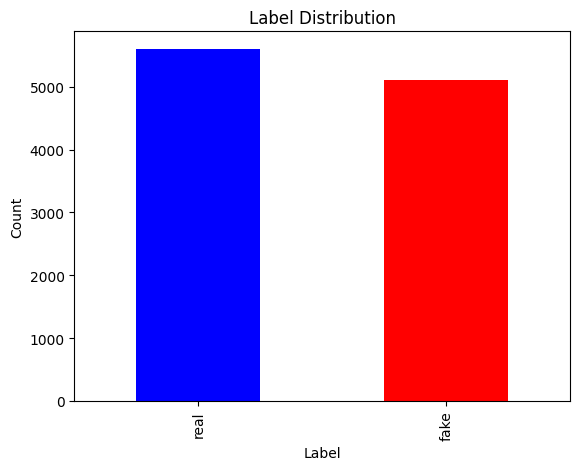

In [137]:
data["label"].value_counts().plot(kind="bar", color=["blue", "red"])
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

According to the graph above, the number of tweets labeled as “real” are slightly higher than those labeled as “fake”, although the percentage is quite similar and does not pose any class imbalance problem.

Another important thing when analyzing this dataset is to check which are the most repeated words in the *real* tweets and in the *fake* tweets. To do this, we are going to use `WordCloud()` to visualize the frequency of words in each category. This will give us insights into the key terms used in tweets labeled as *real* and *fake* and help us understand potential linguistic patterns or biases in the dataset.

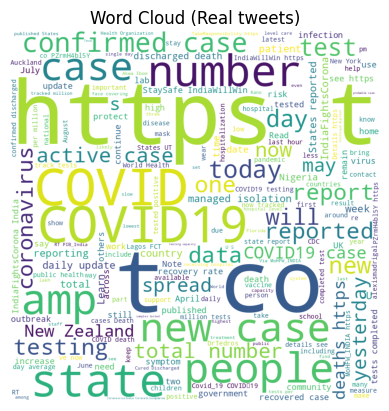

In [138]:
# Plotting the word cloud for real tweets
plt.imshow(WordCloud(width=800, height=800, background_color="white").generate(" ".join(data[data["label"] == "real"]["tweet"])))
plt.axis("off")
plt.title("Word Cloud (Real tweets)")
plt.show()

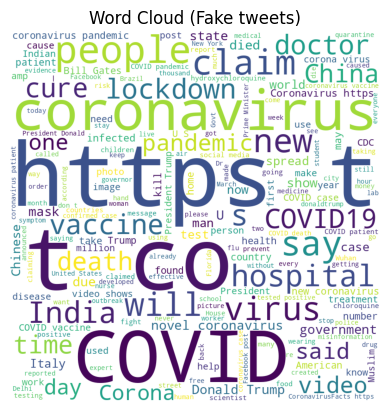

In [139]:
# Plotting the word cloud for fake tweets
plt.imshow(WordCloud(width=800, height=800, background_color="white").generate(" ".join(data[data["label"] == "fake"]["tweet"])))
plt.axis("off")
plt.title("Word Cloud (Fake tweets)")
plt.show()

# Preprocessing

In this section, data will be preprocessed and other important features will be extracted from the initial information in order to more fully and rigorously analyze the data.

### Tweet length

Next, we get some other interesting data such as the average length of tweets according to their label.

In [140]:
data['tweet_length'] = data['tweet'].apply(len)
data.head()

,id,tweet,label,tweet_length
0,1,The CDC currently reports 99031 deaths. In gen...,real,190
1,2,States reported 1121 deaths a small rise from ...,real,129
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake,131
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,204
4,5,Populous states can generate large case counts...,real,231


In [141]:
# Show a tweet text and the corresponding label
n = 527

print(data["tweet"][n])
print(data["label"][n])

IMPORTANT INFO FOR SURGICAL MASK USERS 😷

✅ White side facing outwards if you want to protect yourself. 

✅ If you have flu, blue or green side facing outwards to prevent the germs from spreading outwards.

#COVID19Pakistan #COVID2019 #CoronaVirusUpdate
fake


Outliers will be removed only to check the distribution according to the length of the tweet as a function of its label. In this way, we will be able to study if there is any relationship between the length of the tweet and its label without taking into account the noise that may be caused by the use of outliers.

In [142]:
# Remove the outliers
Q1 = data['tweet_length'].quantile(0.25)
Q3 = data['tweet_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data_tweet_length_outliers_removed = data[(data['tweet_length'] > lower_bound) & (data['tweet_length'] < upper_bound)]

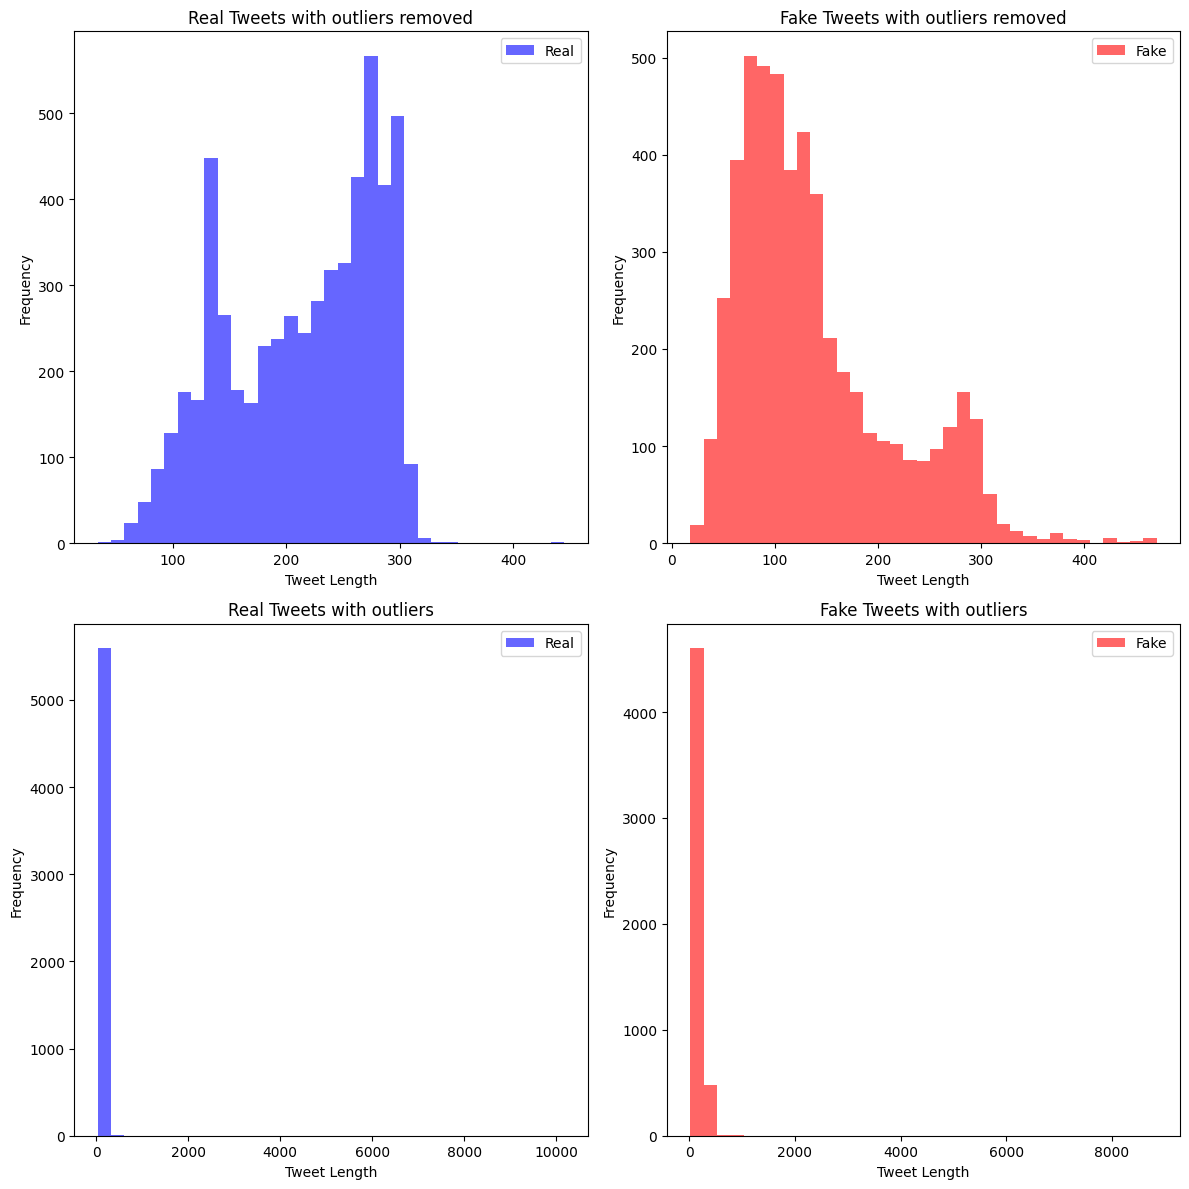

In [143]:
# Plot the distribution of training real and fake tweets
plt.figure(figsize=(12, 12))

# Plot with outliers removed
plt.subplot(2, 2, 1)
plt.hist(data_tweet_length_outliers_removed[data_tweet_length_outliers_removed['label'] == 'real']['tweet_length'], bins=35, label='Real', color='blue', alpha=0.6)
plt.title('Real Tweets with outliers removed')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(data_tweet_length_outliers_removed[data_tweet_length_outliers_removed['label'] == 'fake']['tweet_length'], bins=35, label='Fake', color='red', alpha=0.6)
plt.title('Fake Tweets with outliers removed')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend()

# Plot with outliers
plt.subplot(2, 2, 3)
plt.hist(data[data['label'] == 'real']['tweet_length'], bins=35, label='Real', color='blue', alpha=0.6)
plt.title('Real Tweets with outliers')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 4)
plt.hist(data[data['label'] == 'fake']['tweet_length'], bins=35, label='Fake', color='red', alpha=0.6)
plt.title('Fake Tweets with outliers')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

To validate this hypothesis with data, we will calculate the skewness of the length of tweets as a function of their label. In addition, we will also analyze other interesting metrics such as the mean and median tweet length.

In [144]:
# Data skewness
data_real_skew = data_tweet_length_outliers_removed[data_tweet_length_outliers_removed['label'] == 'real'].tweet_length.skew()
data_fake_skew = data_tweet_length_outliers_removed[data_tweet_length_outliers_removed['label'] == 'fake'].tweet_length.skew()
print("\n-----DATA-----")
print(f"Real skewness: {data_real_skew}")
print(f"Fake skewness: {data_fake_skew}")


-----DATA-----
Real skewness: -0.3799960115599488
Fake skewness: 1.064083258455458


In [145]:
# Data real tweet_length mean and median
data_real_mean = data_tweet_length_outliers_removed[data_tweet_length_outliers_removed['label'] == 'real'].tweet_length.mean()
data_real_median = data_tweet_length_outliers_removed[data_tweet_length_outliers_removed['label'] == 'real'].tweet_length.median()
print(f"Label: 'real', Mean: {data_real_mean}, Median: {data_real_median}")

# Data fake tweet_length mean and median
data_fake_mean = data_tweet_length_outliers_removed[data_tweet_length_outliers_removed['label'] == 'fake'].tweet_length.mean()
data_fake_median = data_tweet_length_outliers_removed[data_tweet_length_outliers_removed['label'] == 'fake'].tweet_length.median()
print(f"Label: 'fake', Mean: {data_fake_mean}, Median: {data_fake_median}")

Label: 'real', Mean: 215.00357270453733, Median: 227.0
Label: 'fake', Mean: 137.90192989365892, Median: 118.0


We can draw the following conclusions about the `tweet_lenght`:

- Tweets labeled `real` have a moderate negative skewness, which means that the distribution is shifted to the left and therefore longer tweets are more frequent. To be more precise, the mean number of characters used in tweets labeled `real` is 215.00 and the median 227.0.

- The tweets labeled `fake` have a high positive skewness, which means that the distribution is quite shifted to the right and, therefore, shorter tweets are more frequent. To be more precise, the mean number of characters used in `fake` labeled tweets is 137.90 and the median 118.0.

# BERTopic

## Embeddings

In [146]:
embedding_model = SentenceTransformer("abhinand/MedEmbed-large-v0.1") # El inicial era ""sentence-transformers/all-MiniLM-L6-v2"
embeddings = embedding_model.encode(train["tweet"])

There are different models to obtain embeddings, some of them are:

- **Sentence Transformers**: `Sentence Transformers` are neural network-based models with `Transformer` architecture designed to create dense vector representations (embeddings) of text. These models convert sentences, paragraphs or documents into vectors of fixed size $v \in \mathbb{R}^d$, where $d$ is the dimension of the vector space. The vector representation $v$ captures the semantic meaning, allowing operations such as similarity matching and clustering.


- **TF-IDF**: Term Frequency-Inverse Document Frequency (TF-IDF) embeddings are a statistical technique used to represent words in text based on their frequency within a document and their rarity in a corpus. It is calculated as the product of two components:

    1. **Term Frequency (TF)**: The frequency of a term $t$ in a document $d$, calculated as:
        $$\text{TF}(t, d) = \frac{\text{number of times t appears in d}}{\text{total number of terms in d}}$$

    2. **Inverse Document Frequency (IDF)**: The occurrence of a term $t$ e in all documents in the collection. Rarer terms that appear in fewer documents get higher **IDF score**. It can be calculated as follows:
    $$\text{IDF}(t) = \log\left(\frac{N}{1 + \text{df}}\right)$$
        
    The **embedding TF-IDF** of a term in a document is obtained by multiplying both values:
    $$\text{TF-IDF}(t,d) = \text{TF}(t,d) \times \text{IDF}(t)$$


- **Word2Vec**: `Word2Vec` is a neural network-based model that learns to represent words as dense vectors in a high-dimensional space. This model is trained using two main architectures: **Skip-gram** and **Continuous Bag of Words (CBOW)**. Both are based on the prediction of words based on their context.

    1. **Skip-gram**: Given a context $C = \{w1,w2,...,w_{m}\}$, where $w_{1}$ is the target word, the model tries to predict the context words from the target word $w_{1}$. The probability that a word $w$ is in the given context $w_{1}$ is modeled as:
    $$P(w | w_1) = \frac{\exp(\mathbf{v'}_{w_0}^T \mathbf{v}_{w_1})}{\sum_{w=1}^{W} \exp(\mathbf{v'}_{w}^T \mathbf{v}_{w_1})}$$
     
    where $v'_{w_0}$ y $v_{w_1}$ are the word vectors for $w_0$ and $w_1$ respectively, and $W$ is the total vocabulary.

    2. **CBOW (COntinous Bag of Words)**: (Still to be completed)

    In both cases, the model seeks to maximize the probability that words in the context of a target word are correctly represented, resulting in vector representations of words (embeddings).

    The resulting **Word2Vec** embeddings capture semantic relationships between words, so that words with similar meanings are grouped together in the vector space. For example, the relationship “king - man + man + woman = queen” can be approximated by operations in vector space, reflecting semantic relationships. In addition, Word2Vec does not take into account the global context of words in a complete text. The model learns semantic relationships based on local patterns in the text and does not take into account global information such as the overall topic of a document or the meaning a word may acquire depending on its position within the full text.

## Dimensionality Reduction

In [147]:
umap_model = UMAP(n_neighbors=20, n_components=10, metric='cosine', random_state=42, low_memory=False) # PCA

For this problem, we will use UMAP, since the embeddings obtained using the SentenceTransformer model present a nonlinear structure. UMAP is particularly suitable for this type of data, as it allows preserving complex local relationships by focusing on the neighborhood topology in the high dimensionality space. Unlike PCA, which identifies directions of maximum variance and is more effective for data with linear structures, UMAP captures more subtle and nonlinear local patterns, making it ideal for analyzing complex semantic relationships in the generated embeddings.

> **Source**: https://www.proquest.com/docview/2473295334?pq-origsite=gscholar&fromopenview=true&sourcetype=Scholarly%20Journals
"PCA projection identifies directions of maximal variance in the data and ignores variation along other directions, it tends to obscure finer-scale patterns of population structure. Many nonlinear neighbour graph-based dimension reduction algorithms, such as t-SNE [3], have been developed over the years to overcome this limitation"

In addition, the `cosine` has been used as a metric. The justification for this is that, given two vectors *a* and *b* of dimensionality *d*, the similarity between them can be calculated by this formula:

$$
similarity(a,b) = \cos(\theta) = \frac{\mathbf{a} \cdot \mathbf{b}}{\|\mathbf{a}\| \|\mathbf{b}\|}
$$


The main reason for using the cosine of the angle formed between the two vectors is that, the value of cos(θ) varies between:
- **1**: when the vectors are perfectly aligned (angle of 0∘).
- **0**: when the vectors are orthogonal (angle of 90∘).
- **-1**: when the vectors are completely opposite (180∘ angle).

From this formula, with UMAP we will be grouping according to the semantics between the different embeddings, providing us with a better solution.

As for the `n_neighbors` parameter, if we use small values, the representation of the data will focus on the local relationships, while a larger value will cause it to focus more on the global structure of the data.

## Clustering

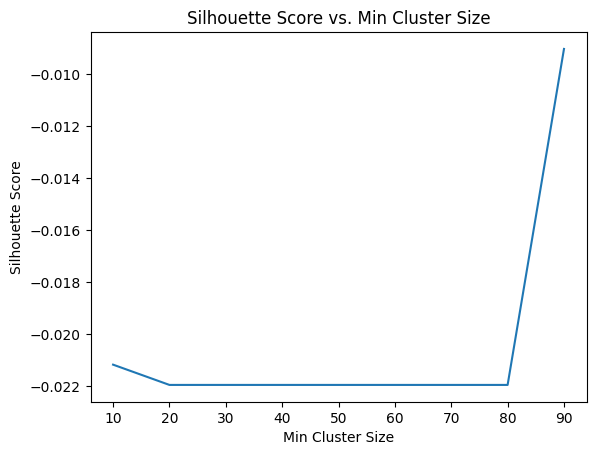

In [148]:
from sklearn.metrics import silhouette_score

min_cluster_sizes = range(10, 100, 10)
silhouette_scores = []

for size in min_cluster_sizes:
    cluster = HDBSCAN(min_cluster_size=size, metric='euclidean', prediction_data=True)
    cluster.fit(umap_model.fit_transform(embeddings))
    silhouette_scores.append(silhouette_score(embeddings, cluster.labels_))

plt.plot(min_cluster_sizes, silhouette_scores)
plt.title("Silhouette Score vs. Min Cluster Size")
plt.xlabel("Min Cluster Size")
plt.ylabel("Silhouette Score")
plt.show()

In [149]:
# Get the min_cluster_size based on the silhouette_score
min_cluster_size = silhouette_scores.index(max(silhouette_scores))*10 + 10
print(f"Min cluster size: {min_cluster_size} (Empirically the best value is 15)")

# Modify min_cluster_size value based on experience
min_cluster_size = 15

cluster_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

Min cluster size: 90 (Empirically the best value is 15)


**HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)** is a clustering algorithm that stands out for its robustness and flexibility, especially on complex data such as tweets. Among some of its features of interest for this problem are the following:

- **No number of clusters required**: A strength of **HDBSCAN** is that it does not require the number of clusters to be specified in advance. The algorithm discovers the data structure autonomously. This is ideal for this problem, since, in principle, it is not known in advance how many topics (clusters) exist in the tweets.

- **Identification of outliers**: Points that do not clearly belong to any cluster are identified as noise. This allows to detect tweets that are not too relevant, which is useful for cleaning and analysis.

- **Variable density clusters**: **HDBSCAN** can identify clusters with different densities, this allows it to adapt to the reality of text data where topics may have different density levels.

As for **K-means**, it is a popular clustering algorithm known for its simplicity and computational efficiency, but it has certain limitations. Among the features of this algorithm of importance for this problem are the following:

- **Simplicity, computational efficiency and scalability**: In certain contexts, this feature may be of vital importance, however, for this problem (we have a not very high number of tweets), it is not a great advantage.

- **Assume uniform density**: **K-means** assumes that the clusters have similar density. This algorithm groups the data by trying to separate samples into *n* clusters of equal variance, minimizing a criterion known as the *incerity* or sum of squares within the cluster.
$$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$$

- **Noise sensitivity**: It is very sensitive to outliers and noise in the data. Outliers can significantly affect the position of cluster centroids, which can lead to suboptimal results.

The choice among the HDBSCAN parameters was made for the following reasons:

1. **Metric**: This parameter defines the distance metric used to calculate the distance between points. Some of the most commonly used values are:
    - `'euclidean'`: It has been decided to use this one because it is one of the most common and also, the dimensionality of the data is relatively low because *Dimensionality Reduction* has been previously done.

    - `'cosine'`: It is preferably used for high dimensionality data in which the angle of the vectors is more important than the absolute distance. For this reason, it has been decided to discard this metric.

2. **Cluster Selection Method**: This parameter determines how HDBSCAN selects the final clusters after the hierarchical clustering process. Among the options are:
    - `'eom'` (Excess of Mass): This method is typically used when you want to extract clusters that represent high density areas. The clusters are identified based on the criterion of “excess of mass”, which tries to identify which are the areas of higher density. It has been decided to use this method to try to better group tweets with the same theme.

    - `'leaf'`: This method chooses clusters based on the 'leaf' criterion, which means that it selects dense regions in the cluster tree where the hierarchy ends. This can often result in a more refined and less aggressive clustering process.

3. **Min Cluster Size**: The optimum value for this parameter was obtained empirically. A range between 10 and 100 with steps of 10 has been defined, the silhouette coefficient has been calculated and the value of *min_cluster_size* that offered the highest coefficient has been used. However, the most “optimal” *min_cluster_size* value according to silhouette produces very few *topics* and therefore very little useful information, with 15 being the best empirically tested value.

## Vectorizers

In [150]:
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1,2))

## Topic representation

In [151]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

## Fine Tuning

In [152]:
representation_model = KeyBERTInspired()

## Model setup and training

In [153]:
topic_model = BERTopic(
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=cluster_model,
  vectorizer_model=vectorizer_model,
  ctfidf_model=ctfidf_model,
  representation_model=representation_model,
  calculate_probabilities = True,
  min_topic_size = 50,
  n_gram_range=(1, 2),
  verbose = True,
  language='english'
)

In [154]:
topics, probs = topic_model.fit_transform(train["tweet"])

2025-01-22 18:36:23,762 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/201 [00:00<?, ?it/s]

2025-01-22 18:37:54,356 - BERTopic - Embedding - Completed ✓
2025-01-22 18:37:54,357 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-22 18:38:10,582 - BERTopic - Dimensionality - Completed ✓
2025-01-22 18:38:10,584 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-22 18:38:11,663 - BERTopic - Cluster - Completed ✓
2025-01-22 18:38:11,670 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-22 18:38:27,236 - BERTopic - Representation - Completed ✓


## Visualization

In [ ]:
topic_model.visualize_topics()

In [155]:
topics_per_class = topic_model.topics_per_class(train["tweet"], train["label"])
topic_model.visualize_topics_per_class(topics_per_class)

2it [00:23, 11.75s/it]


# Conclusion

**Put the conclusion here**

In addition to all the information and conclusions mentioned above, other possible questions have been raised whose study could be interesting and could help to differenciate more clearly between *real* and *fake* tweets. Some of these are the following:

- It could be interesting to extract tags from tweets (eg: #coronavirus) and study if there is any relationship between *fake* tweets and certain tags. This is because the use of hashtags is usually oriented to maximize the reach of tweets to a specific audience or to promote content related to specific topics, which in some cases could be associated with conspiracy groups or similar.

- Another possible idea related to the urls present in some tweets is to check the trustworthiness of the site using some heuristic between the reliability of the web page and the comments people have posted using some tools such as [MyWOT](https://www.mywot.com/scorecard).  Sometimes links to websites included in tweets can provide us with quite a bit of information. For example, some tweets contain a url that redirects to a web page called *[www.thespoof.com](www.thespoof.com)* on which there are untrustworthy fake news, political satire, and funny parody.

- It could be analyzed whether the citation of certain organizations or people influence whether a tweet is labeled as “real” or “fake”.